# cu_inj Reference simulation

In [49]:
# %pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

In [171]:
from impact import Impact
from distgen import Generator
import os
from pmd_beamphysics.plot import density_and_slice_plot, slice_plot
NAME = 'impact_cu_inj_v0_300k_particles'
import matplotlib.pyplot as plt
GFILE = os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/vcc_image/distgen.yaml')
#GFILE = os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/v0/distgen.yaml')
# YFILE = os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/v0/ImpactT.yaml')
infile = os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/v0/ImpactT.in')
IFILE = os.path.expandvars(infile)

In [172]:
%%time
G = Generator(GFILE)
G['n_particle'] = 300_000
G.run()
P0 = G.particles

CPU times: user 4.37 s, sys: 1.48 s, total: 5.85 s
Wall time: 3.38 s


# MPI run 300k particles

For this many particles we will prepare an MPI run

In [173]:
# I = Impact.from_yaml(YFILE)
I = Impact(IFILE, workdir=os.path.expandvars('$SCRATCH'))
# Set initial particles
I.initial_particles = P0
I.workdir=os.path.expandvars('$SCRATCH')
## Switches for MPI
I.numprocs = 60
I.stop = 16.5
I.mpi_run

'mpirun -n {nproc} {command_mpi}'

In [174]:
# Change some things
I.header['Nx'] = 64
I.header['Ny'] = 64
I.header['Nz'] = 64

# Run on S3DF

This will run on SLAC's S3DF. Note that you must have access to a partition (allocation) for instant response.

In [175]:
 # SDF setup    
settings = { 
 'command': '/sdf/group/ad/beamphysics/software/impact-T/single_processor/ImpactTexe',    
 'command_mpi': '/sdf/group/ad/beamphysics/software/impact-T/openmpi/ImpactTexe-mpi',
 'mpi_run': 'salloc --partition milano --account ad:beamphysics -N 1 -n {nproc} /usr/lib64/openmpi/bin/mpirun -n {nproc} {command_mpi}'
}
for k, v in settings.items():
    I[k] = v
    
I.workdir = os.path.expandvars('$SCRATCH')
I.configure()
print(I)

================ Impact-T Summary ================    
300000 particles
1 bunch of electrons
total charge: 250.0000000000001 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 6.515803466731775e-12 s
   image charges neglected after z = 0.02 m
Processor domain: 4 x 15 = 60 CPUs
Space charge grid: 64 x 64 x 64
Maximum time steps: 1000000
Reference Frequency: 2856000000.0 Hz
Initial reference time: -3.249141278122655e-12 s
Simulation starting from the beginning
Impact-T configured in /sdf/scratch/users/j/jmorgan/tmpasid5w_8


In [176]:
%%time
I.verbose=True
I.run()

Running Impact-T in /sdf/scratch/users/j/jmorgan/tmpasid5w_8
salloc --partition milano --account ad:beamphysics -N 1 -n 60 /usr/lib64/openmpi/bin/mpirun -n 60 /sdf/group/ad/beamphysics/software/impact-T/openmpi/ImpactTexe-mpi
writing 300000 particles to /sdf/scratch/users/j/jmorgan/tmpasid5w_8/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 300000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 7.397329755843176e-12 according to initial particles
Cathode start: Replaced Tini with -3.7045312932654324e-12 according to initial particles
Setting total charge to 2.500000000000001e-10 C


salloc: Pending job allocation 44737487
salloc: job 44737487 queued and waiting for resources
salloc: job 44737487 has been allocated resources
salloc: Granted job allocation 44737487
salloc: Waiting for resource configuration
salloc: Nodes sdfmilan203 are ready for job


 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.2
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           32          32
 check randomness:            7  0.78532225288656377     
 check randomness:            9  0.59031183341447335     
 check randomness:           10  0.60153481933799990     
 check randomness:           11  0.81638064904260244     
 check randomness:           12  0.74470811726626351     
 check randomness:           13   1.6634878363575689E-002
 check randomness:           14  0.50110506036000768     
 check randomness:           15  0.79204185913161529     
 check randomness:           16  0.24540457978378527     
 time:    478.56981748200002, elapsed: 696.38832330703748340130723391, elapsed: 695.0705940723419631006

salloc: Relinquishing job allocation 44737487
salloc: Job allocation 44737487 has been revoked.


Finished.
Loaded fort 26 : RMS Z information
Loaded fort 27 : Max amplitude information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 18 : Time and energy
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 24 : RMS X information
Loaded fort 25 : RMS Y information
Loaded fort 70 : Slice information of the final distribution
Loaded fort 60 : Slice information of the initial distribution
Loading particles
Loaded fort 50 : final particle distribution projected to the centroid location of the bunch
Loaded fort 40 : initial particle distribution at t = 0
Loaded write beam particles YAG02 fort.102
Loaded write beam particles YAG03 fort.103
Loaded write beam particles WS01 fort.104
Loaded write beam particles OTR1 fort.105
Loaded write beam particles WS02 fort.106
Loaded write beam particles OTR2 fort.107
Loaded write beam particles WS03 fort.108
Loaded write beam particle

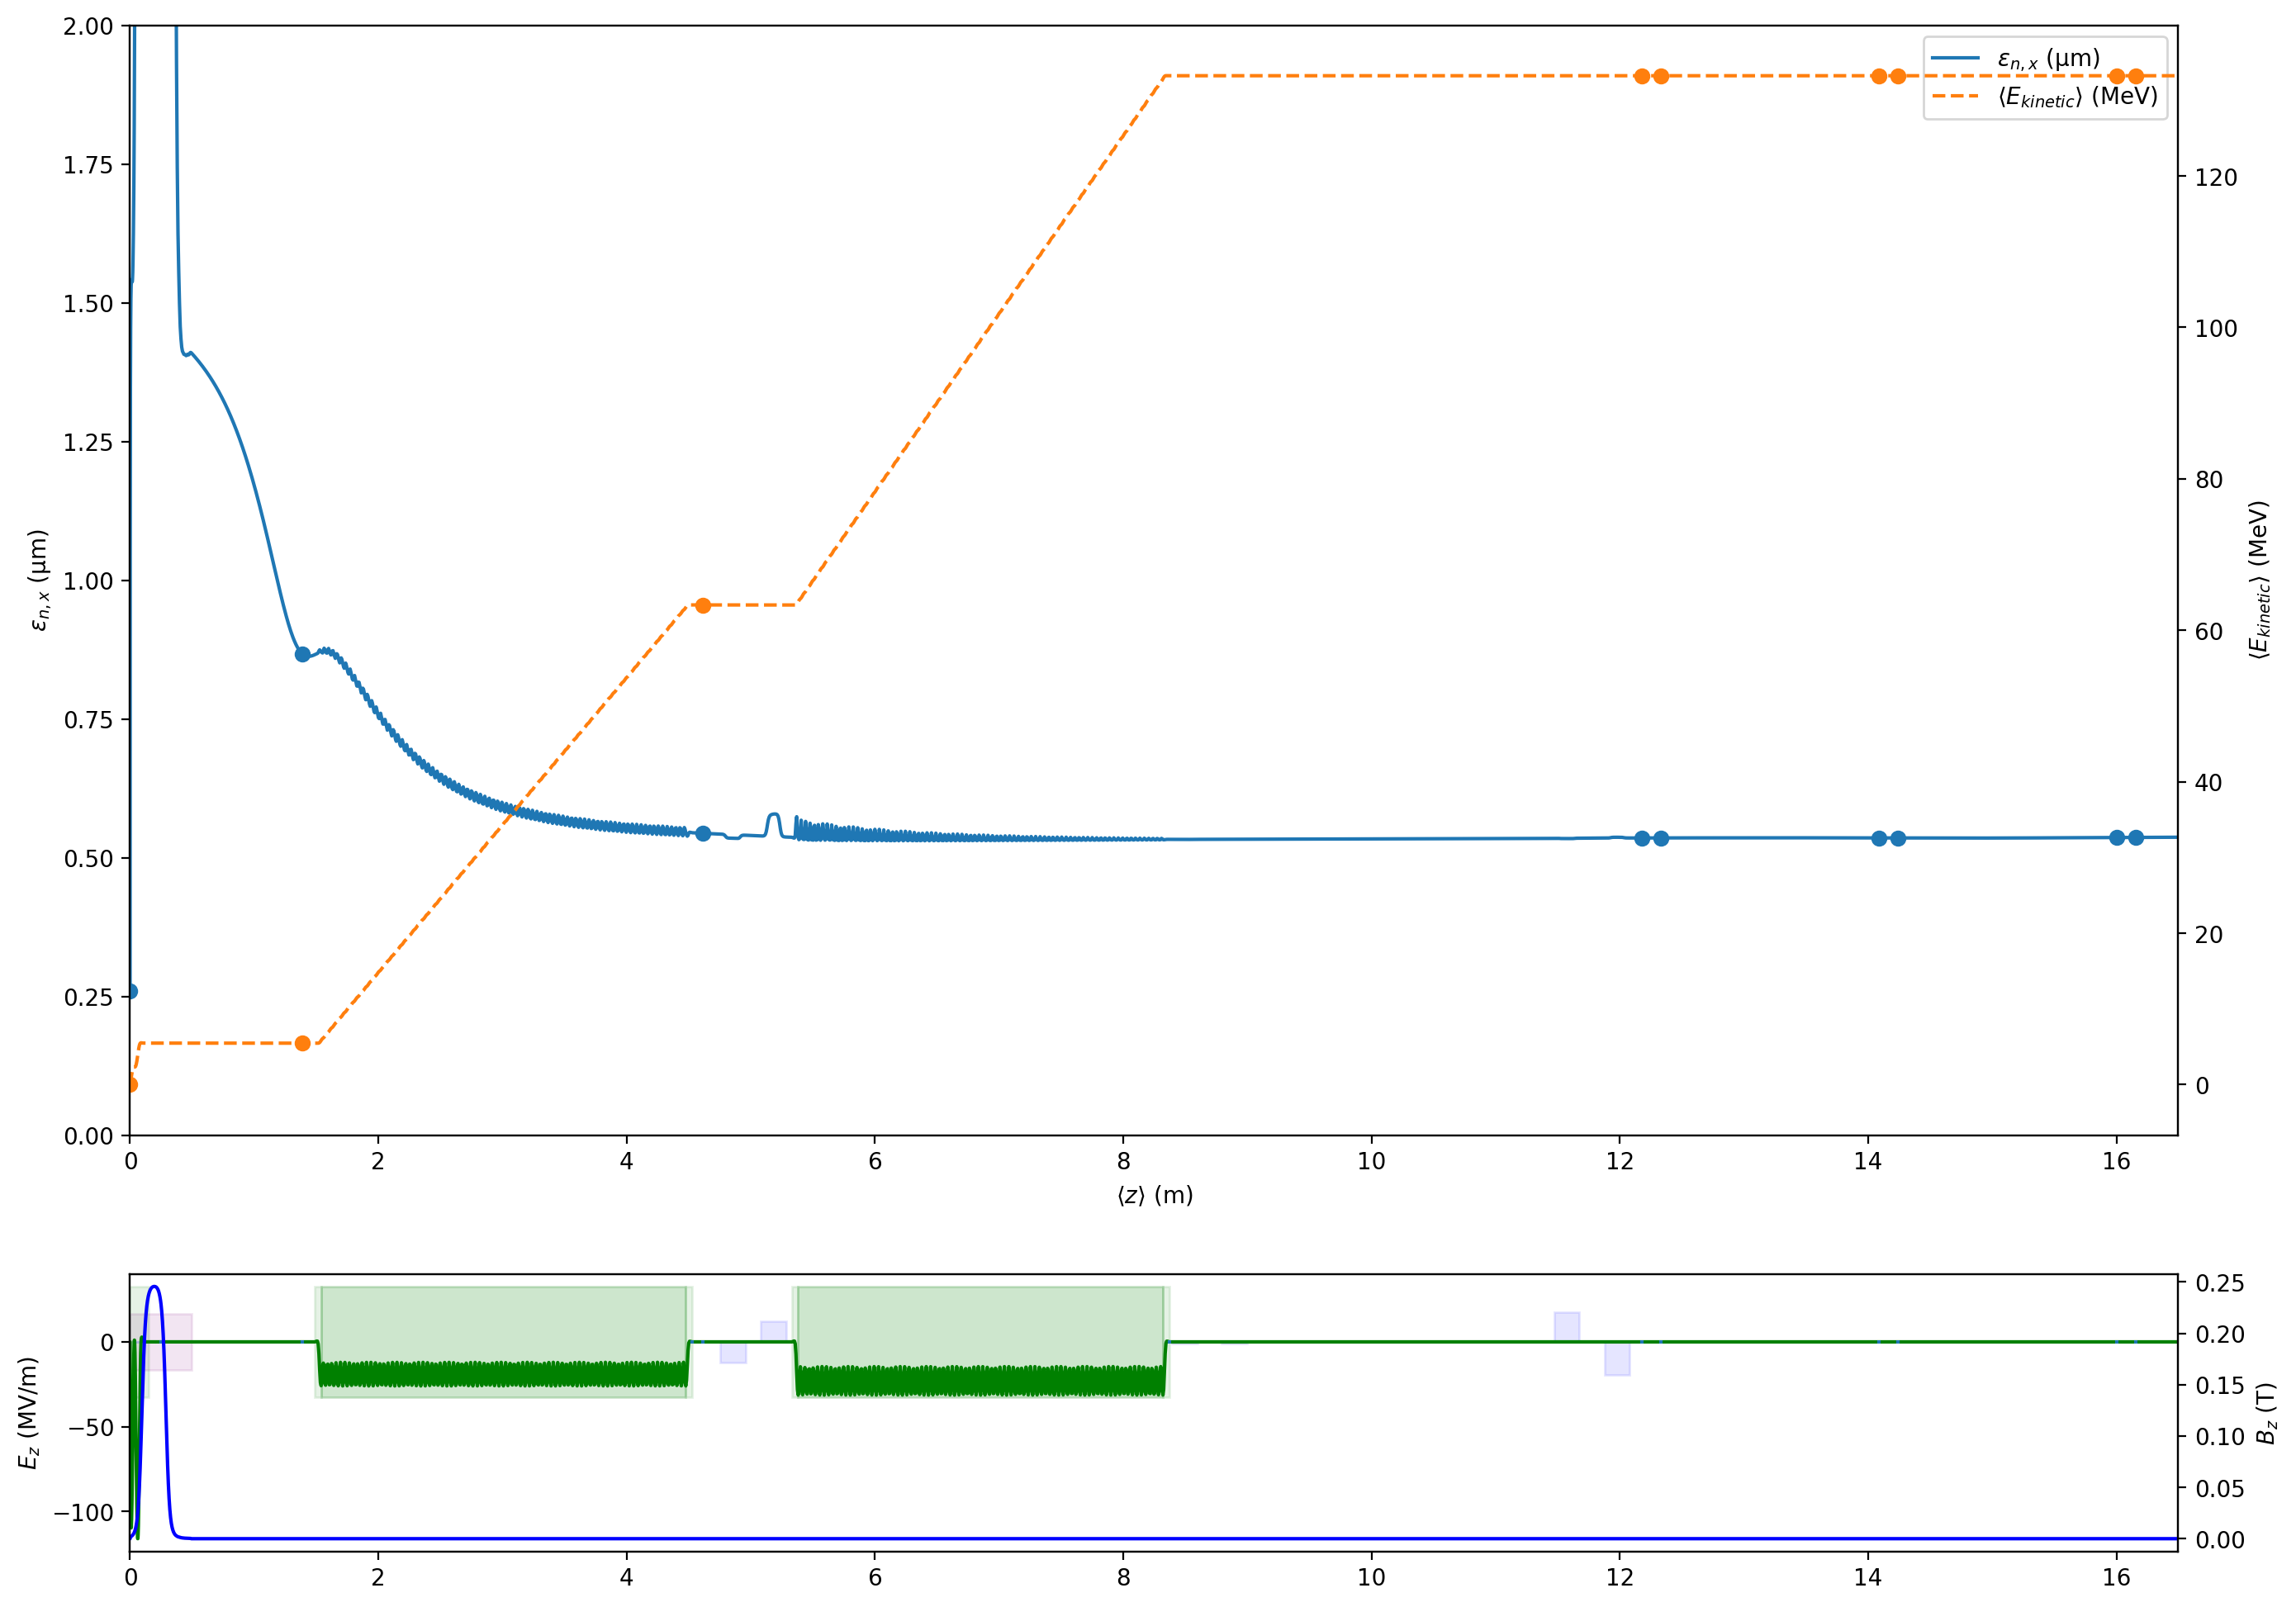

In [177]:
I.plot('norm_emit_x', y2='mean_kinetic_energy', ylim=(0, 2e-6), figsize=(16,12), include_labels=False)

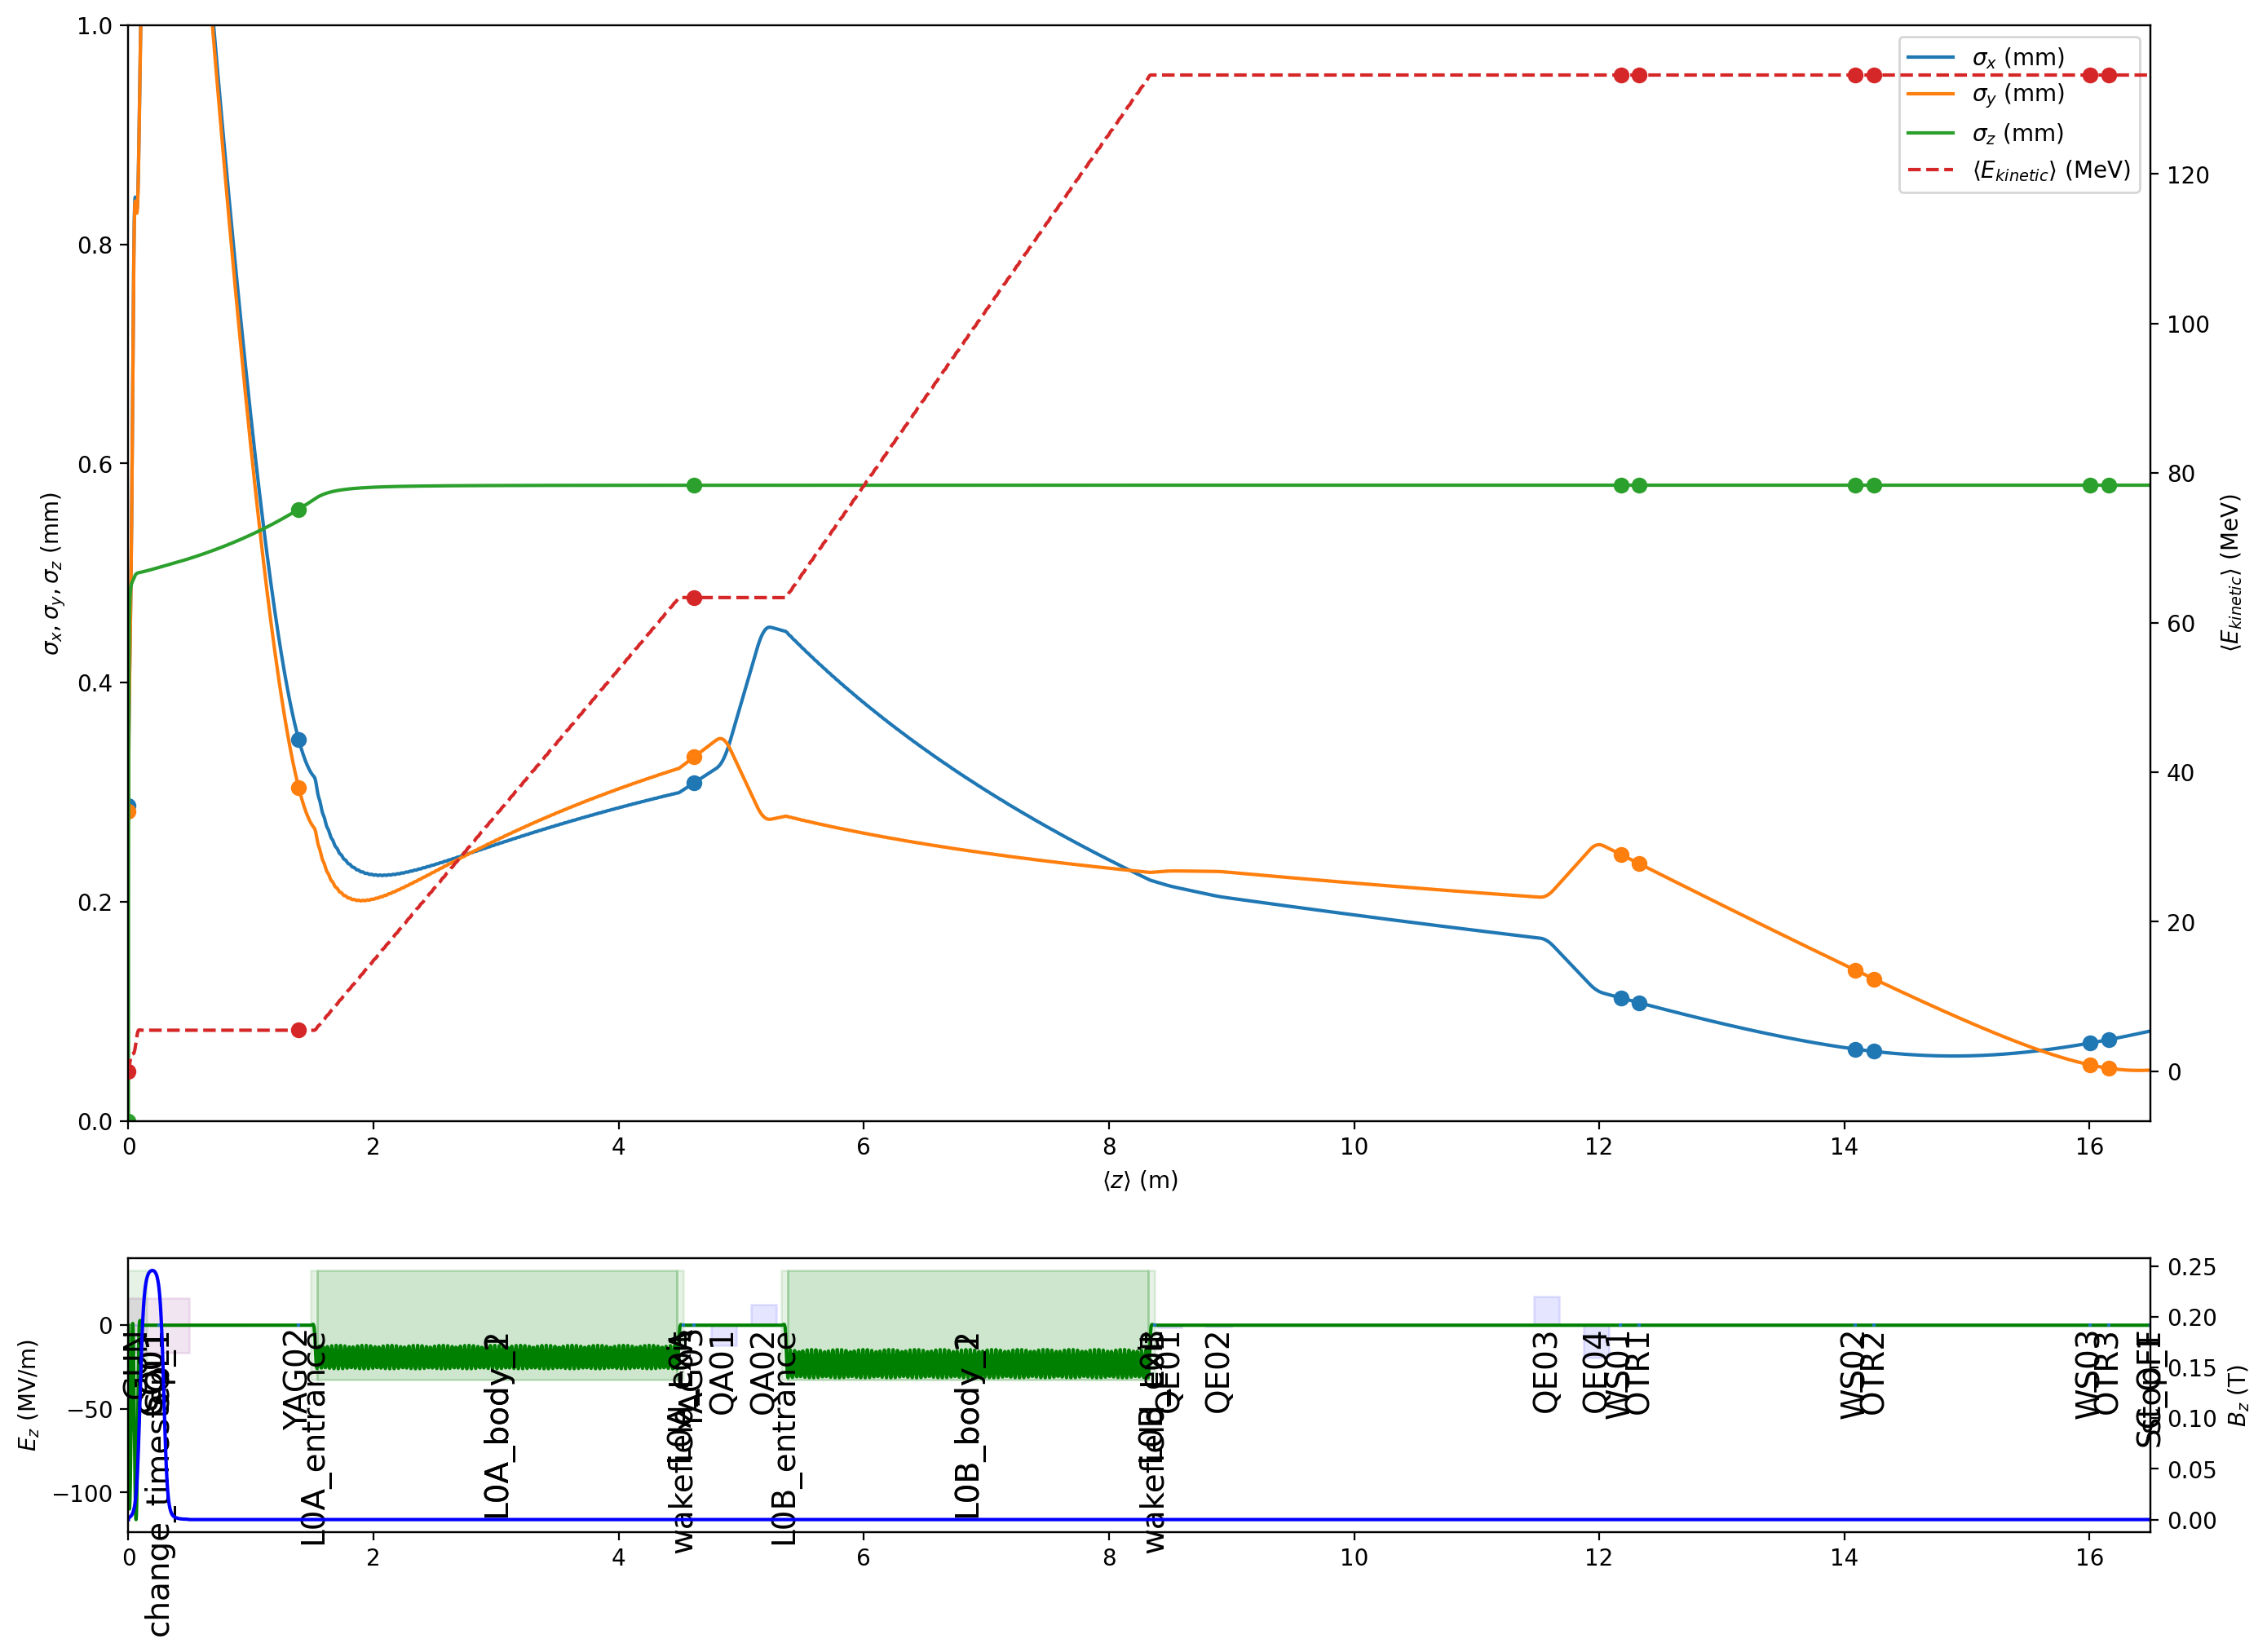

In [178]:
I.plot(['sigma_x', 'sigma_y', 'sigma_z'], y2='mean_kinetic_energy',  ylim=(0, 0.001), xlim=(0, 16.5), figsize=(16, 12), include_labels=True)

In [179]:
I.particles.keys()

dict_keys(['final_particles', 'initial_particles', 'YAG02', 'YAG03', 'WS01', 'OTR1', 'WS02', 'OTR2', 'WS03', 'OTR3'])

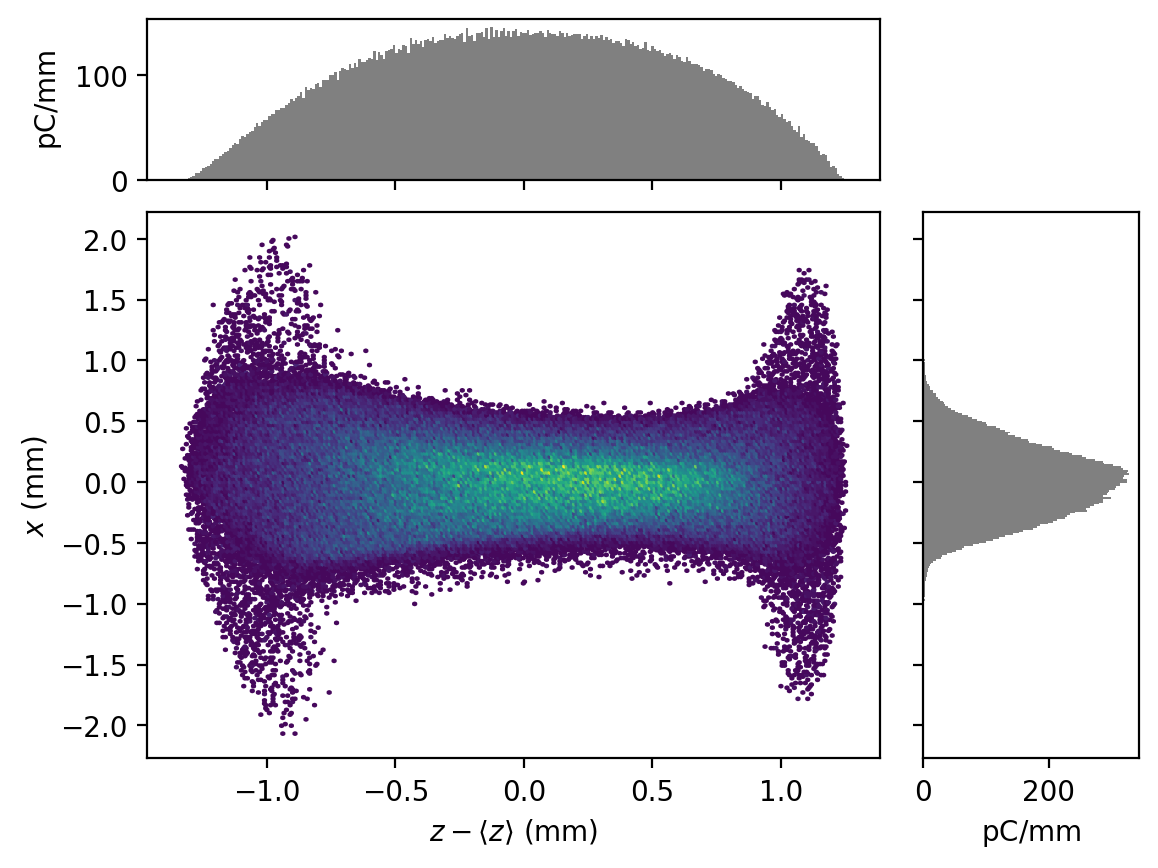

In [180]:
P1 = I.particles['YAG03']

P1.plot('delta_z', 'x')

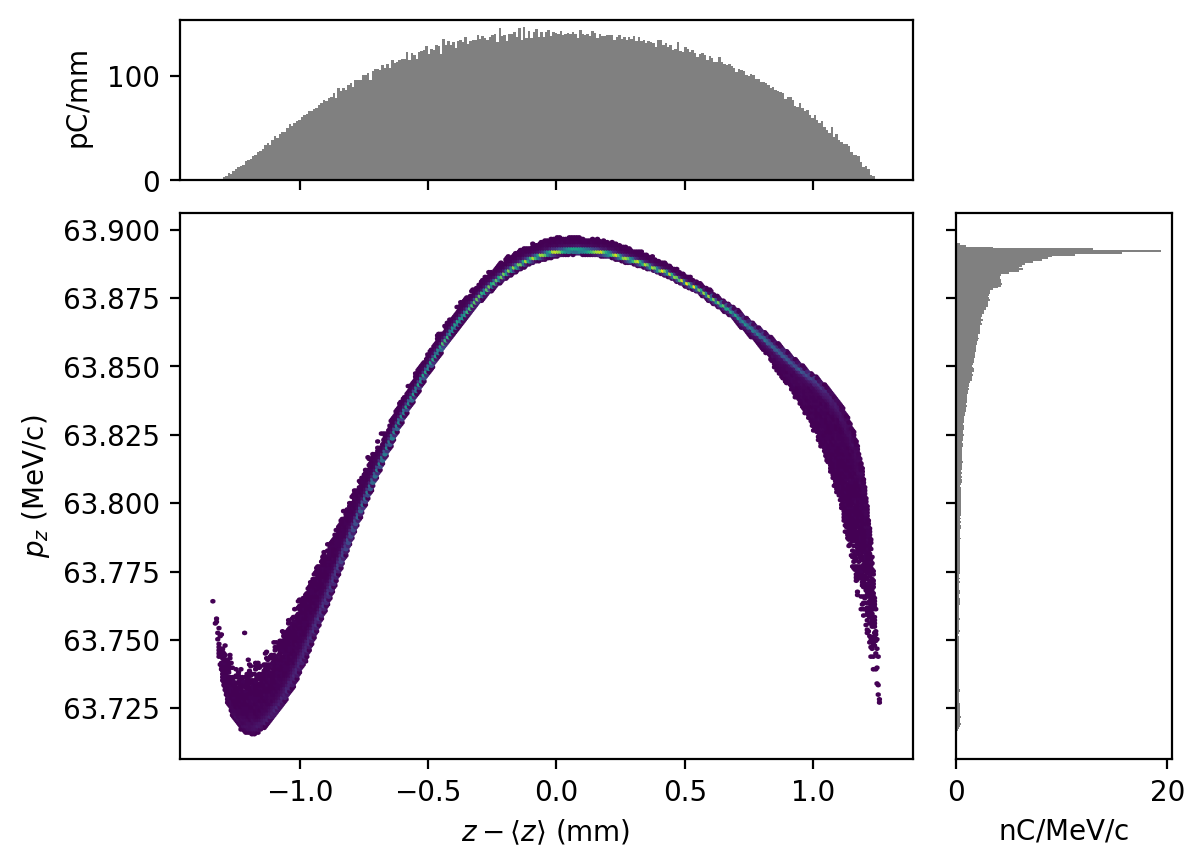

In [181]:
P1.plot('delta_z', 'pz')

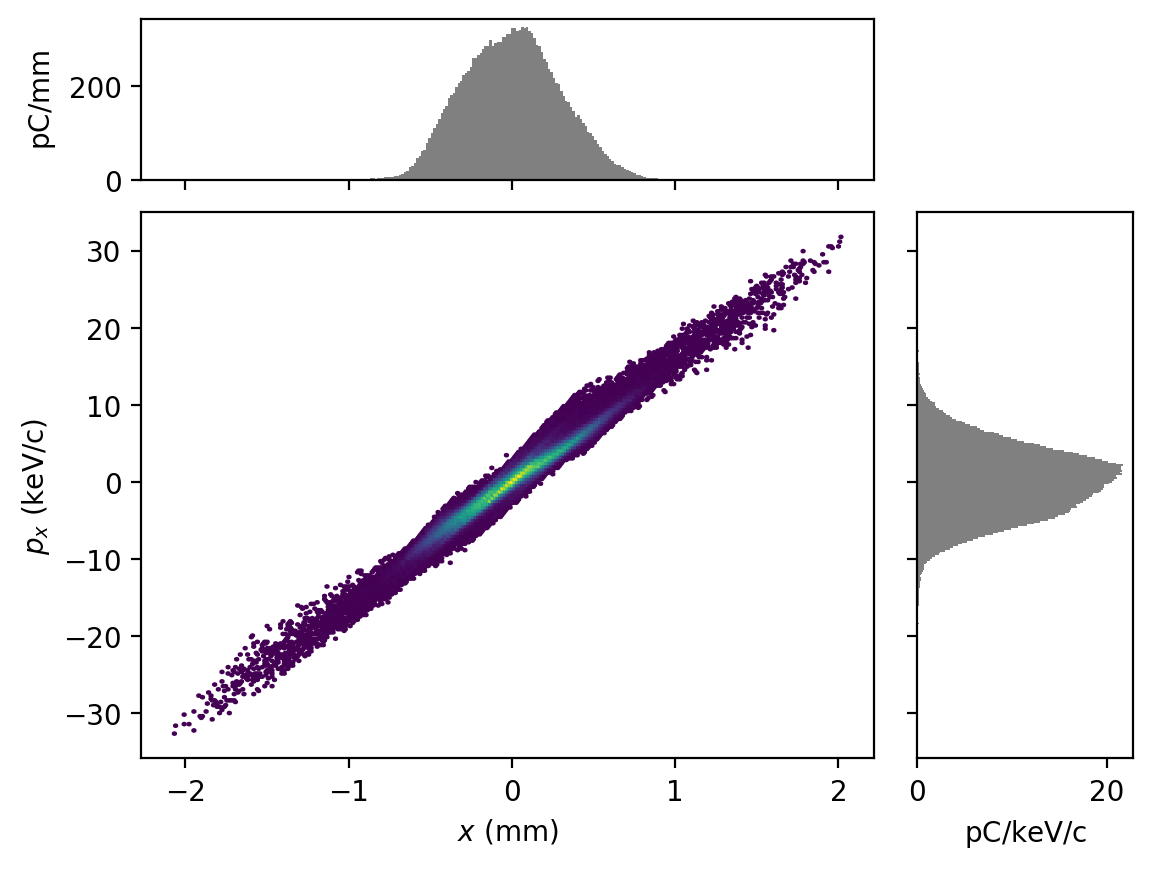

In [182]:
P1.plot('x', 'px')

In [183]:
# 95% Twiss and Emittance
P1.twiss('xy', 0.95)

{'alpha_x': -5.36134915740214,
 'beta_x': 23.301566832756894,
 'gamma_x': 1.2764834657282793,
 'emit_x': 3.3523564246579826e-09,
 'eta_x': -0.027688003754267398,
 'etap_x': -0.004762731519808384,
 'norm_emit_x': 4.189384697527008e-07,
 'alpha_y': -5.856903288508317,
 'beta_y': 23.202974492281484,
 'gamma_y': 1.521499588024081,
 'emit_y': 3.520966704098155e-09,
 'eta_y': 0.022397858321739822,
 'etap_y': 0.003990320173668037,
 'norm_emit_y': 4.4000795301902327e-07}

In [184]:
PFILE0 = './linac/impact_inj_output.h5'
I.particles['YAG03'].write(PFILE0)

# Inject IMPACT output into Tao/PyTao

In [185]:
from pytao import Tao
from pmd_beamphysics import ParticleGroup

## Parameters

In [186]:
TRACK_START ="YAG03" # Where to start particle tracking (injection element)
TRACK_END = "ENDCLTH_0"#"WSDL31" #"HXRCB1END" #"BC1CEND" # Where to end particle tracking
# Get particles from Lume-Impact sc_inj model, e.g.: 
# I.particles['final_particles'].write('impact_particles_at_14m.h5')

#PFILE0 =  '/sdf/home/j/jmorgan/lclsrepo_dontsharethese/lcls-lattice/bmad/beams/YAG03_100k.h5'
PFILE0 = './linac/impact_inj_output.h5'
# File to write
PFILE = f'bmad_particles_at_{TRACK_START}.h5' 

# Twiss Match parameters (optional) 
twiss_match = True


## Initialize Tao and get reference time

### Running BMAD Simulations with Graphical Output on S3DF Jupyter Notebook

To run BMAD simulations with graphical output on S3DF Jupyter Notebook, follow these steps:

1. **Find the Hostname:**
   - Run the command `hostname` to find out the hostname of the machine where the Jupyter is running.
2. **Establish SSH Connection with X11 Forwarding:**
   - From your local machine, use SSH with X11 forwarding enabled:
     ```bash
     ssh -Y <your-username>@<remote-hostname>
     ```
     For example:
     ```bash
     ssh -Y zihanzhu@s3dflogin
     ```
   - Then, SSH to the specific iana node:
     ```bash
     ssh -Y zihanzhu@sdfiana008
     ```
   - Retrieve the DISPLAY variable using:
     ```bash
     echo $DISPLAY
     ```
3. **Set DISPLAY Environment Variable in Notebook:**
   - Back to Jupyter, set the DISPLAY environment variable in the notebook:
     ```bash
     %env DISPLAY=<DISPLAY variable>
     ```
Now, the graphical interface should appear when you run BMAD with Tao/PyTao. Special thanks to Michael Enrlichman for guidance.



In [187]:
#%env DISPLAY=:44.0  #may need to uncomment this 

In [188]:
tao = Tao('-lat $LCLS_LATTICE/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [189]:
tao = Tao(f'-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice BEGINNING:{TRACK_END}')
#tao = Tao(f'-init $LCLS_LATTICE/bmad/models/cu_hxr/tao.init -slice {TRACK_START}:{TRACK_END}')
tao.cmd('place floor sigmaxy')


[]

In [190]:
t_ref = tao.evaluate(f'ele::{TRACK_START}[ref_time]')[0]

t_ref

1.5413714264595368e-08

# Prepare particles

In [191]:
P = ParticleGroup(PFILE0)

# Change to s-coordinates (different times t, constant z)
P.drift_to_z() # drift to P['mean_z']

# Zero out the mean time
P.t += t_ref -P['mean_t']



if twiss_match:
   P.twiss_match(plane='y',beta=tao.lat_list("YAG03",'ele.a.beta'),alpha=tao.lat_list("YAG03",'ele.a.alpha'),inplace=True) 
   P.twiss_match(plane='x',beta=tao.lat_list("YAG03",'ele.b.beta'),alpha=tao.lat_list("YAG03",'ele.b.alpha'),inplace=True)

# Write the file that Tao will read
P.write(PFILE)



# Check particles

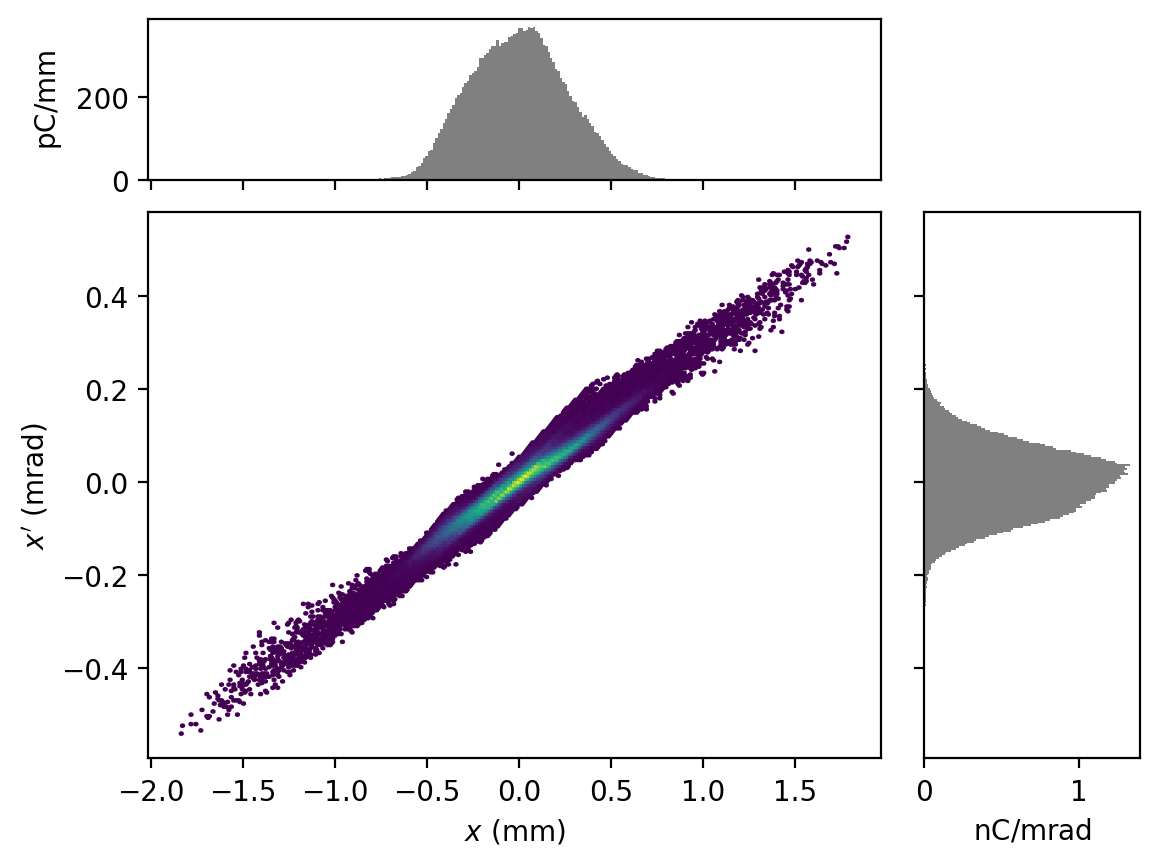

In [192]:
P.plot('x', 'xp')


In [193]:
P.twiss('xy')

{'alpha_x': -4.826402559204063,
 'beta_x': 17.270081936376624,
 'gamma_x': 1.4067195368841785,
 'emit_x': 4.318161739732105e-09,
 'eta_x': -0.025679430361474003,
 'etap_x': -0.004550533138730758,
 'norm_emit_x': 5.396244297768368e-07,
 'alpha_y': -4.821155130919839,
 'beta_y': 17.262108256087473,
 'gamma_y': 1.4044366097545016,
 'emit_y': 4.989810887506602e-09,
 'eta_y': 0.017949553306795936,
 'etap_y': 0.002594153388653838,
 'norm_emit_y': 6.235578973547318e-07}

# # Set initial beam 

In [194]:
tao.cmd('set global plot_on = F')
tao.cmd('set global lattice_calc_on = F')
tao.cmd(f'set beam_init position_file = {PFILE}')
tao.cmd(f'set beam_init track_start = {TRACK_START}')
tao.cmd(f'set beam_init track_end = {TRACK_END}')
tao.cmd(f'set beam_init bunch_charge = {P.charge}')
tao.cmd(f'set beam_init n_particle = {len(P)}')
tao.cmd('set global lattice_calc_on = T')
tao.cmd('set global plot_on = T')


#tao.cmd('call $LCLS_LATTICE/bmad/models/cu_hxr/scripts/Activate_CSR.tao')
#tao.cmd('csron')

[]

# Track

In [195]:
# Toggle beam
#tao.cmd('set global track_type = beam;set global track_type = single') 
tao.cmd('set global track_type = beam') # default mode is "single"

['Beam at Element: 412. Time: 1 min',
 'Beam at Element: 656. Time: 2 min',
 'Beam at Element: 912. Time: 3 min',
 'Beam at Element: 1163. Time: 4 min',
 'Beam at Element: 1425. Time: 5 min']

# Get partices at end

In [196]:
P1 = ParticleGroup(data=tao.bunch_data('ENDCLTH_0'))

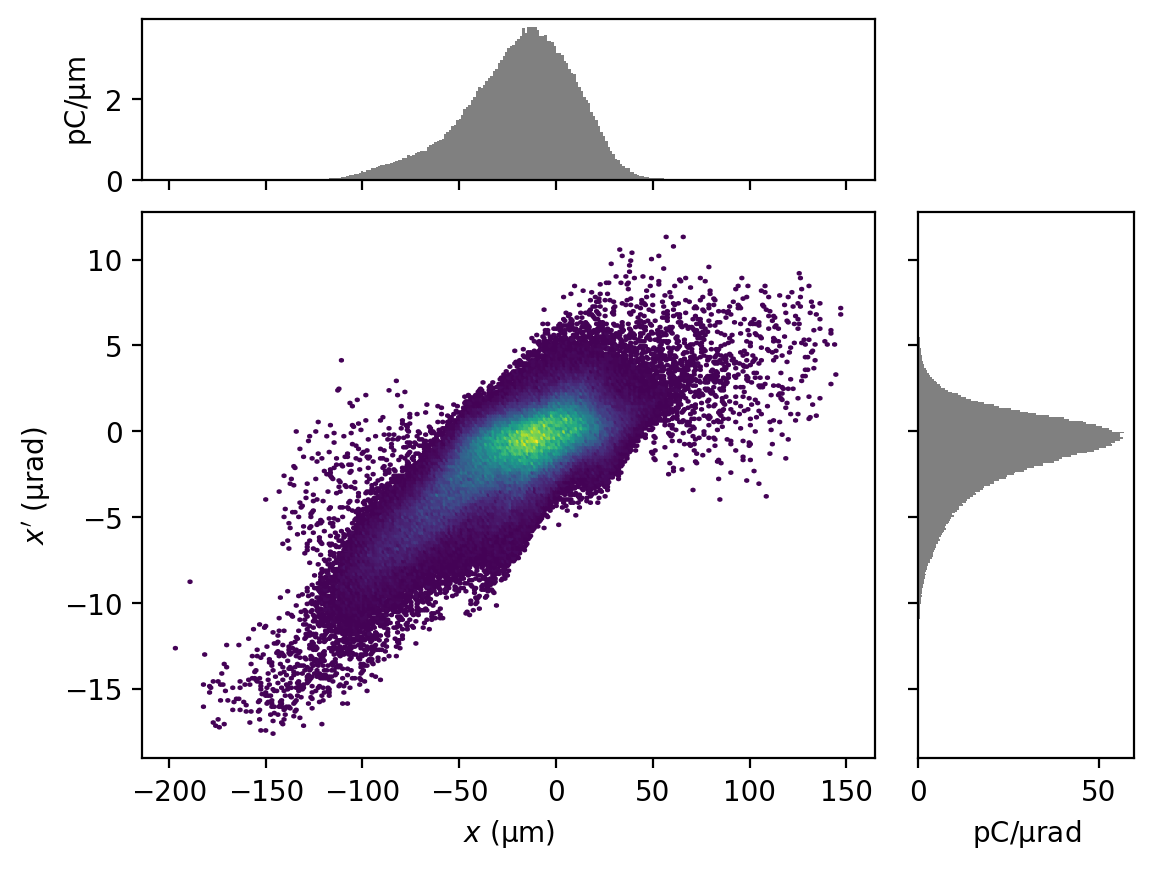

In [197]:
P1.plot('x', 'xp')

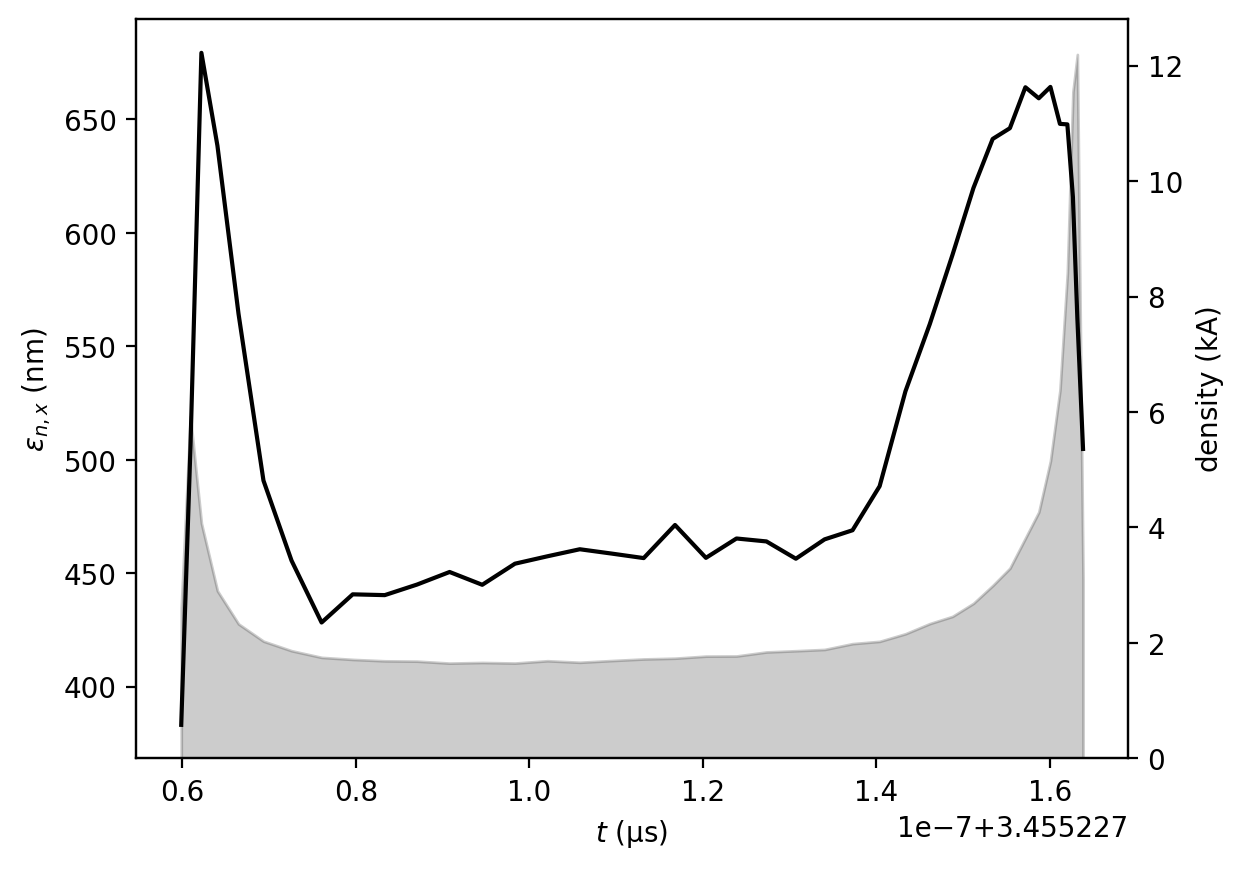

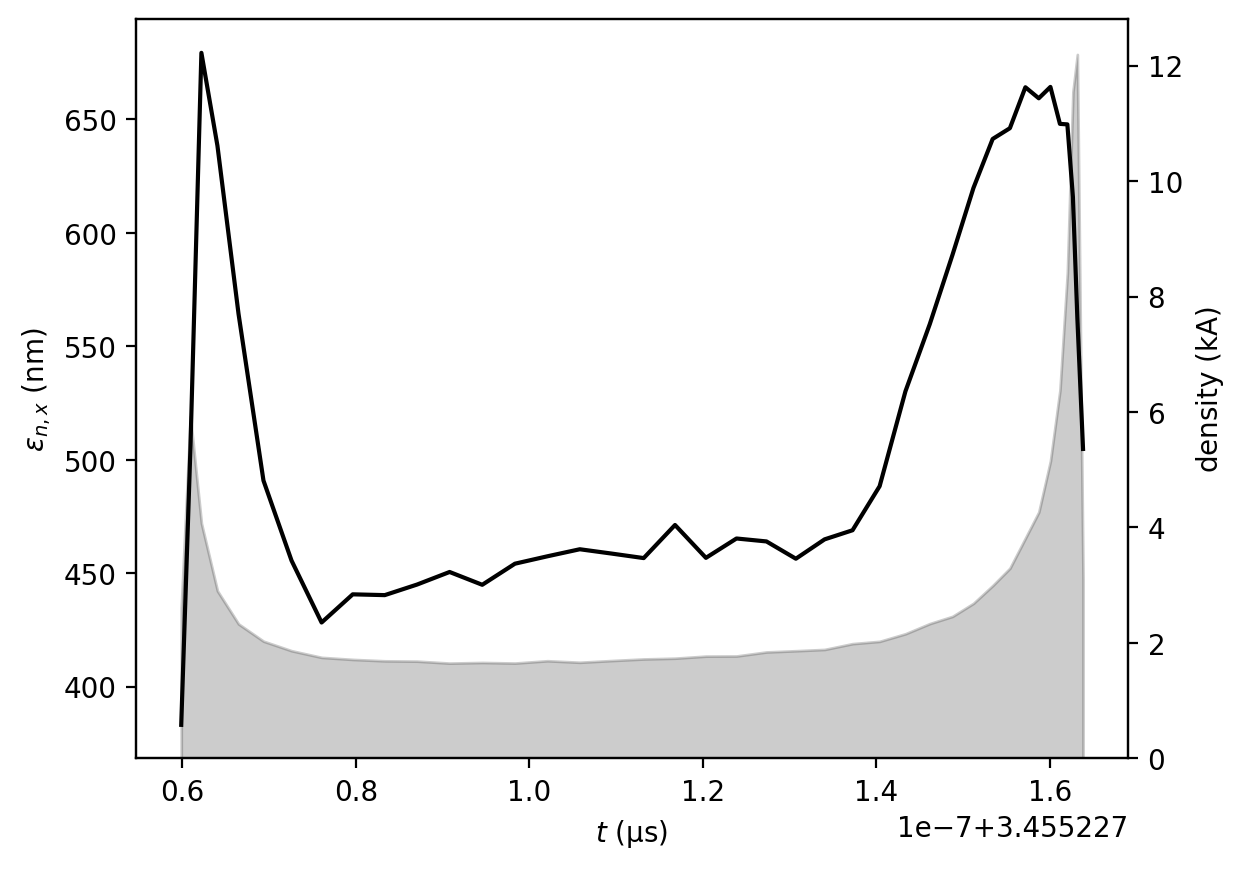

In [198]:
slice_plot(P1, 'norm_emit_x', slice_key='t')

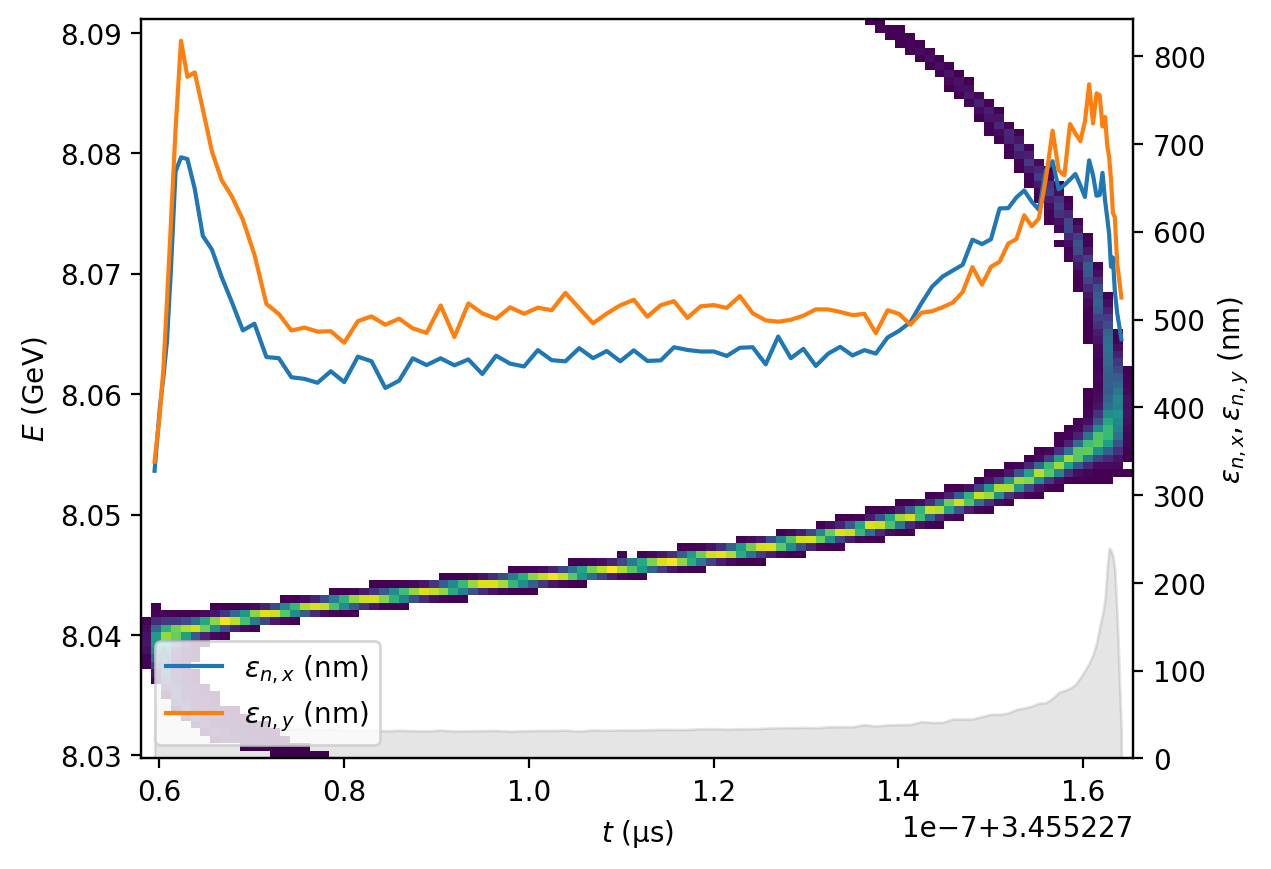

In [199]:
density_and_slice_plot(P1, 't', 'energy', stat_keys = ['norm_emit_x', 'norm_emit_y'], n_slice = 100, bins=100)
#plt.xlim(4.2, 4.3)

## Plot

In [200]:
%%tao
x-a all s
sc

-------------------------
Tao> x-a all s
-------------------------
Tao> sc
-------------------------
Tao> 


# Save the files

In [201]:
PFILE02 = './linac/Tao_output.h5'
P1.write(PFILE02)

# Genesis Simulations

In [202]:
from genesis.version4 import Genesis4
from genesis import tools

### Read in an match the beam

In [203]:
PFILE0 = './linac/Tao_output.h5'
P1 = ParticleGroup(PFILE0)
NSAMPLE = len(P1)
P1 = P1.resample(NSAMPLE)

twiss_match = True
alpha_x0 = -0.7393217413918415 
beta_x0 = 7.910909406464387
alpha_y0 = 1.3870723536888105 
beta_y0 = 16.8811786213468987

# Change to s-coordinates (different times t, constant z)
P1.drift_to_z() # drift to P['mean_z']

#t_ref=0
# Zero out the mean time
#P1.t += t_ref -P1['mean_t']

if twiss_match:
    P1.twiss_match(beta =  beta_x0  , alpha =alpha_x0, plane = 'x', inplace = True)
    P1.twiss_match(beta =  beta_y0  , alpha =alpha_y0, plane = 'y', inplace = True)

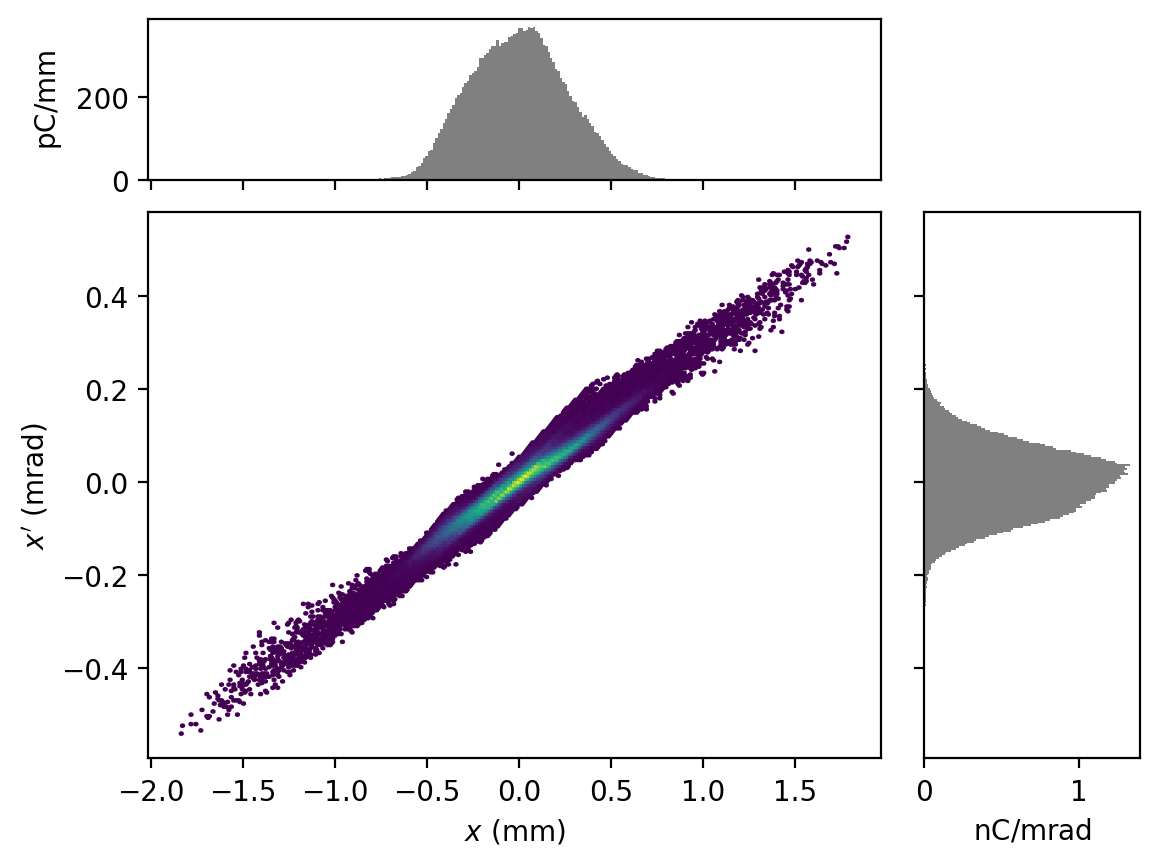

In [204]:
P.plot('x', 'xp') #Lets check we have the right beam

## Set up the simulation using the lcls repo files

In [209]:
# Get the relevant files and directories
run_file_location=os.path.expandvars('$LCLS_LATTICE/genesis/version4/cu_hxr/')
run_file=os.path.expandvars('cu_hxr.in')
workdir=os.path.expandvars('$SCRATCH')

G = Genesis4(run_file_location + run_file, workdir=workdir, verbose = True)

Configured to run in: /sdf/scratch/users/j/jmorgan/tmpgxc6pgdd


In [210]:
nproc=16
G.nproc = nproc
# here we can make changes to the input files for this simulatin run in scratch
gamma=15750.807133238239 
lamda0=2.041420496336648e-10
G.input['main'][0]['gamma0'] = gamma # if we need to change gamma0
G.input['main'][0]['lambda0']= lamda0 # lamda needs to change is gamma undulator strength in lat file au=:1.7017

G.input['main'].append({'type': 'write', 'beam': 'end'})  # this writes out the particles at the ened of the simulation

# Now use the partilce data, this will right the particles in the file format the Genesis expects. 
G.initial_particles = P1

G.write_input(path=G.path, input_filename=run_file)

Initial particles written to /sdf/scratch/users/j/jmorgan/tmpgxc6pgdd/genesis4_importdistribution.h5
Updated slen = 3.219878703412121e-05
Removed 'beam' from input, will be replaced by 'importdistribution'
Added new importdistribution before the first track
Setting use_mpi = True because nproc = 16


In [ ]:
# we are ready to run genesis
G.write_input(path=G.path, input_filename=run_file)
runscript = "salloc --partition milano --account ad:beamphysics --mem-per-cpu=4g  -n {nproc} mpirun -n {nproc} {command_mpi} {inputfile}".format(nproc = G.nproc, command_mpi = G.command_mpi, inputfile = G.path + '/' + run_file)
log = []
for path in tools.execute(runscript.split(), cwd=G.path):
    G.vprint(path, end="")
    log.append(path)
G.vprint("Finished.")

Initial particles written to /sdf/scratch/users/j/jmorgan/tmpgxc6pgdd/genesis4_importdistribution.h5
Updated slen = 3.219878703412121e-05
Updated existing importdistribution


salloc: Pending job allocation 44737842
salloc: job 44737842 queued and waiting for resources
salloc: job 44737842 has been allocated resources
salloc: Granted job allocation 44737842
salloc: Waiting for resource configuration
salloc: Nodes sdfmilan201 are ready for job


---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by conda at 2024-01-11 18:02:26 [UTC] from Git Commit ID: 226c27d5b1b045a8195218d2ce5d63aaa10537c7
Starting Time: Mon Apr 22 13:01:39 2024

MPI-Comm Size: 16 nodes

Opened input file /sdf/scratch/users/j/jmorgan/tmpgxc6pgdd/cu_hxr.in
Parsing lattice file hxr.lat ...
Setting up time window of 32.6627 microns with 800 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Importing distribution file... 
Charge of external distribution: 2.5e-10
Particles in external distribution: 300000
*** Non-matching PArticle Transfar: Rank: 1 Deleted: 16812 Forward: 14053 Backward: 3332
*** Non-matching PArticle Transfar: Rank: 2 Deleted: 17279 Forward: 12776 Backward: 4903
*** Non-matching PArticle Transfar: Rank: 3 Deleted: 17544 Forward: 11754 Backward: 6109
*** Non-matching PArticle Transfar: Rank: 4 Dele

In [ ]:
G.log = log
G.load_output()
G.plot('field_energy', yscale='log', y2 = ['field_xsize', 'field_ysize'], ylim2=(0e-6, 150e-6))

In [ ]:
G.load_particles()
P1 = G.particles['end']
P1.drift_to_z()
P1.plot('t', 'energy')
P1